Covid-19 Dataset was downloaded from: https://www.kaggle.com/datasets/meirnizri/covid19-dataset

In [1]:
#libraries
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import missingno as msno

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.linear_model import LogisticRegression
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split

#Libraries for Forward Selection
import joblib
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


from scipy import stats
import os
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

#!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
file = ('/content/Covid _19 _Dataset.csv')  
#covid_ori_df is the original data
covid_ori_df = pd.read_csv(file)
covid_ori_df.shape
#covidData = covid_ori_df.copy( deep= True )

(1048575, 21)

In [3]:
# converting missing data as nan in original data

#replace CLASIFFICATION_FINAL with 1,2,3 if patient is in different stages of Covid Exposure and 0 if patient is not a carrier of Covid
covid_ori_df.loc[covid_ori_df['CLASIFFICATION_FINAL']>3, 'CLASIFFICATION_FINAL'] = 0

# replace every column except CLASIFFICATION_FINAL with 97,98 and 99 with nan values and value 1 which is Yes nad 2 which is no is changed to 0
replaceMap_dict = { 1:1, 2:0, 97:np.nan, 98:np.nan, 99:np.nan, '9999-99-99':0 }
covidData_noClassification = covid_ori_df.drop(columns = 'CLASIFFICATION_FINAL').replace( replaceMap_dict )

#concat for classification_final column as it was dropped in above step
covid_ori_df = pd.concat(  [ covidData_noClassification, covid_ori_df['CLASIFFICATION_FINAL'] ], axis= 'columns'  )

# changing DATE_DIED column having an actual Date to 1 which is the person has Died Due to covid
covid_ori_df.loc[ covid_ori_df['DATE_DIED'] !=0, 'DATE_DIED' ] = 1
covid_ori_df.DATE_DIED.unique()

array([1, 0], dtype=object)

In [4]:
# impute missing value in original data
covid_ori_df.columns
#dropping 'MEDICAL_UNIT' which has irrelevant data and it does not explain my research question
covid_ori_df.drop( columns= 'MEDICAL_UNIT', inplace= True )
#numerical column
num_col_ls = [ 'CLASIFFICATION_FINAL','AGE' ] 
cat_col_ls = covid_ori_df.drop( columns= num_col_ls ).columns

# impute missing values of categorical column to their mode
for col in cat_col_ls:
    covid_ori_df[col].fillna(covid_ori_df[col].mode()[0], inplace=True)

# impute numerical col: "AGE" to their mean and classification doesn't have missing values
mean_value = covid_ori_df['AGE'].mean()
covid_ori_df['AGE'].fillna(mean_value, inplace=True)

covid_ori_df['Death'] = covid_ori_df['DATE_DIED']
covid_ori_df.drop( columns= 'DATE_DIED', inplace= True )

# convert all dtypes into int
covid_ori_df = covid_ori_df.astype(np.int8)
#covid_ori_df.dtypes

#  label encoding for CLASIFFICATION_FINAL since it is the ordinal variable
label_encoder = sklearn.preprocessing.LabelEncoder()
covid_ori_df['CLASIFFICATION_FINAL'] = label_encoder.fit_transform( covid_ori_df['CLASIFFICATION_FINAL'] )
#covid_ori_df

# one hot encoding for categorical binary nominal variable
miss_cat_colm = [ 'PATIENT_TYPE','INTUBED', 'PREGNANT', 'ICU', 'USMER', 'SEX', 'Death', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO' ]
OHEncoder = sklearn.preprocessing.OneHotEncoder( sparse= False, drop= 'first', dtype= np.int8 )
OHEncoded_np = OHEncoder.fit_transform( covid_ori_df[miss_cat_colm] )
OHEncoded_df = pd.DataFrame( OHEncoded_np, index= covid_ori_df.index, columns= OHEncoder.get_feature_names_out (miss_cat_colm) )
covid_ori_df = covid_ori_df.drop( miss_cat_colm, axis= 1 )\
                .merge( OHEncoded_df, left_index= True, right_index= True )
cols_to_rename = covid_ori_df.columns[  covid_ori_df.columns.str.endswith('_1') ]
covid_ori_df = covid_ori_df.rename(  columns={col: col.replace('_1', '')  for col in cols_to_rename}  )
cols_to_rename = covid_ori_df.columns[  covid_ori_df.columns.str.endswith('_1') ]
covid_ori_df = covid_ori_df.rename(  columns={col: col.replace('_1', '')  for col in cols_to_rename}  )
#covid_ori_df

Comparing the efficiency of ML without removing outliers

In [5]:
from pandas.compat.numpy.function import CompatValidator
#selecting dependent and independent variable as x and y after imputing missing values in balanced equaltion with random under sampler
x = covid_ori_df.drop( "Death", axis= 1 )
y = covid_ori_df["Death"]
y= y.astype('int') 

random_underS = RandomUnderSampler(random_state=0)
x, y = random_underS.fit_resample(x,y)

x_train, x_test, y_train, y_test= train_test_split( x, y, test_size= 0.3, random_state= 0 )

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Logistic Regression ---------------------------' )
## logistic Regression

LogiReg = LogisticRegression()
LogiReg.fit(x_train, y_train)
predict_LR = LogiReg.predict(x_test)
logiR_score = accuracy_score(y_test, predict_LR)
print(classification_report(y_test,predict_LR))
print("The percentage of accuracy of Logistic Regression is: ", logiR_score)
print('Test Score: ', LogiReg.score(x_test, y_test))
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predict_LR ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predict_LR ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Random Forest ---------------------------' )

## Random Forest
Random_Forest = RandomForestClassifier(  max_depth=6,
                                        max_features=None,
                                        max_leaf_nodes=9,
                                        n_estimators=100 )
Random_Forest.fit(x_train, y_train)
predicted_RF = Random_Forest.predict(x_test)
RF_score = accuracy_score(y_test, predicted_RF)
print(classification_report(y_test,predicted_RF))
print('The percentage of accuracy of Random Forest (on test data) is: ', RF_score )
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_RF ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_RF ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Naive Bayes ---------------------------' )

## Naive Bayes
Nbayes = BernoulliNB()
Nbayes.fit(x_train, y_train)
predicted_NB = Nbayes.predict(x_test)
NB_score = accuracy_score(y_test, predicted_NB)
print(classification_report(y_test,predicted_NB))
print("The percentage of accuracy of Naive-Bayes (on test data) is:", NB_score)
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_NB ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_NB ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Decision Tree ---------------------------' )

## Decision Tree
Decision_T =  DecisionTreeClassifier()
Decision_T.fit(x_train, y_train)
predicted_DT = Decision_T.predict(x_test)
DT_score = accuracy_score(y_test, predicted_DT)
print(classification_report(y_test,predicted_DT))
print("The percentage of accuracy of Decision Tree is (on test data) :", DT_score)
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_DT ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_DT ))


-------------------------------------------------------------------------------------
----------------------------- Logistic Regression ---------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     22803
           1       0.90      0.91      0.91     23363

    accuracy                           0.91     46166
   macro avg       0.91      0.91      0.91     46166
weighted avg       0.91      0.91      0.91     46166

The percentage of accuracy of Logistic Regression is:  0.9050816618290517
Test Score:  0.9050816618290517
Matthewus corr coefficient: 0.8101574216599763
Brier_score is: 0.09491833817094832

-------------------------------------------------------------------------------------
----------------------------- Random Forest ---------------------------
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     22803
           1       0.90      0.92      0.91     233

Removing outliers form my numerical variables

<Axes: >

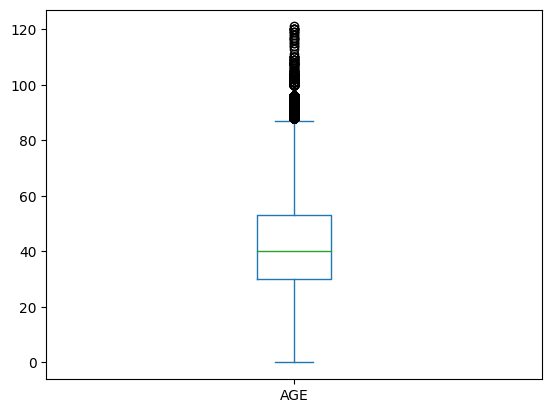

In [6]:
#To remove outliers in my dataset
covid_ori_df.AGE.plot( kind= 'box' )

121 87


<Axes: >

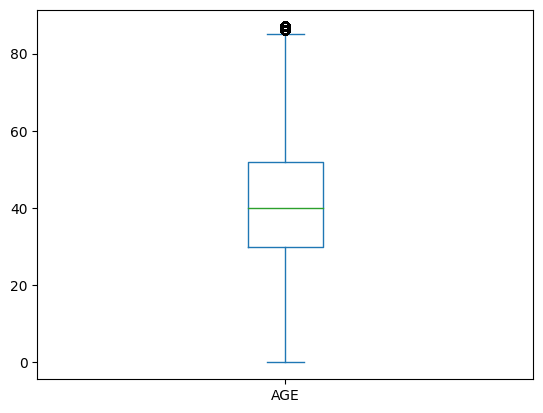

In [7]:
Q1 = covid_ori_df['AGE'].quantile(0.25)
Q3 = covid_ori_df['AGE'].quantile(0.75)
IQR = Q3 - Q1
l_bound = Q1 - (1.5 * IQR)
u_bound = Q3 + (1.5 * IQR)

covid_removeOutlier_df = covid_ori_df[(covid_ori_df['AGE'] >= l_bound) & (covid_ori_df['AGE'] <= u_bound)]
print( covid_ori_df.AGE.max(), covid_removeOutlier_df.AGE.max() )
covid_removeOutlier_df.AGE.plot( kind= 'box' )

Comparing the effieincy of ML models by removing outliers

In [8]:
#selecting dependent and independent variable as x and y
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import datasets
import warnings
warnings.filterwarnings("ignore")

x = covid_removeOutlier_df.drop( "Death", axis= 1 )
y = covid_removeOutlier_df ["Death" ]
y= y.astype('int') 

random_underS = RandomUnderSampler(random_state=0)
x, y = random_underS.fit_resample(x,y)

x_train, x_test, y_train, y_test= train_test_split( x, y, test_size= 0.3, random_state= 0 )

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Logistic Regression ---------------------------' )
## logistic Regression

LogiReg = LogisticRegression()
LogiReg.fit(x_train, y_train)
predict_LR = LogiReg.predict(x_test)
logiR_score = accuracy_score(y_test, predict_LR)
print(classification_report(y_test,predict_LR))
print("The percentage of accuracy of Logistic Regression is: ", logiR_score)
print('Test Score: ', LogiReg.score(x_test, y_test))
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predict_LR ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predict_LR ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Random Forest ---------------------------' )

## Random Forest
Random_Forest = RandomForestClassifier(max_depth=6,
                                      max_features=None,
                                      max_leaf_nodes=9,
                                      n_estimators=100)
Random_Forest.fit(x_train, y_train)
predicted_RF = Random_Forest.predict(x_test)
RF_score = accuracy_score(y_test, predicted_RF)
print(classification_report(y_test,predicted_RF))
print('The percentage of accuracy of Random Forest (on test data) is: ', RF_score )
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_RF ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_RF ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Naive Bayes ---------------------------' )

## Naive Bayes
Nbayes = BernoulliNB()
Nbayes.fit(x_train, y_train)
predicted_NB = Nbayes.predict(x_test)
NB_score = accuracy_score(y_test, predicted_NB)
print(classification_report(y_test,predicted_NB))
print("The percentage of accuracy of Naive-Bayes (on test data) is:", NB_score)
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_NB ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_NB ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Decision Tree ---------------------------' )

## Decision Tree
Decision_T =  DecisionTreeClassifier()
Decision_T.fit(x_train, y_train)
predicted_DT = Decision_T.predict(x_test)
DT_score = accuracy_score(y_test, predicted_DT)
print(classification_report(y_test,predicted_DT))
print("The percentage of accuracy of Decision Tree is (on test data) :", DT_score)
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_DT ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_DT ))



-------------------------------------------------------------------------------------
----------------------------- Logistic Regression ---------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     22353
           1       0.90      0.91      0.91     22744

    accuracy                           0.90     45097
   macro avg       0.90      0.90      0.90     45097
weighted avg       0.90      0.90      0.90     45097

The percentage of accuracy of Logistic Regression is:  0.9041843138124487
Test Score:  0.9041843138124487
Matthewus corr coefficient: 0.8084253776682867
Brier_score is: 0.09581568618755128

-------------------------------------------------------------------------------------
----------------------------- Random Forest ---------------------------
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     22353
           1       0.87      0.95      0.91     227